# Replicating the M4 competition using sktime

Resources: 
* [Github repo of the M4 competition](https://github.com/M4Competition/M4-methods)

## Preliminaries

In [1]:
import sktime
print(sktime.__file__, sktime.__version__, sep='\n')

/Users/mloning/Documents/Research/python_methods/sktime/sktime/__init__.py
0.1.0


In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.utils.validation import check_consistent_length
from tqdm import tqdm
from copy import deepcopy

from sktime.forecasters import DummyForecaster
from sktime.forecasters import ExpSmoothingForecaster
from sktime.forecasters import EnsembleForecaster
from sktime.highlevel import Forecasting2TSRReductionStrategy
from sktime.highlevel import ForecastingStrategy
from sktime.highlevel import ForecastingTask

from losses import mase_loss
from losses import smape_loss

### Set paths

In [6]:
repodir = "/Users/mloning/Documents/Research/python_methods/m4-methods/"
datadir = os.path.join(repodir, "Dataset")
traindir = os.path.join(datadir, 'Train')
testdir = os.path.join(datadir, 'Test')
savedir = os.path.join(repodir, "predictions")

assert os.path.exists(traindir)
assert os.path.exists(testdir)
assert os.path.exists(savedir)

### Load results from M4 competition for comparison

In [7]:
m4_results = pd.read_excel(os.path.join(repodir, 'Evaluation and Ranks.xlsx'), 
                        sheet_name='Point Forecasts-Frequency',
                        header=[0, 1]).dropna(axis=0)

mase = m4_results.loc[:, ['Method', 'MASE']]
mase.columns = mase.columns.droplevel()
mase = mase.set_index('User ID')

smape = m4_results.loc[:, ['Method', 'sMAPE']]
smape.columns = smape.columns.droplevel()
smape = smape.set_index('User ID')

print(mase.shape, smape.shape)

(59, 7) (59, 7)


## Set up experiments
### Import meta data

In [8]:
import pandas as pd
info = pd.read_csv(os.path.join(datadir, 'M4-info.csv'))

In [9]:
info.head()

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00


In [10]:
n_datasets = info.shape[0]
print(n_datasets)

100000


In [11]:
info.category.value_counts()

Micro          25121
Finance        24534
Macro          19402
Industry       18798
Demographic     8708
Other           3437
Name: category, dtype: int64

In [66]:
info.SP.value_counts()

Monthly      48000
Quarterly    24000
Yearly       23000
Daily         4227
Hourly         414
Weekly         359
Name: SP, dtype: int64

In [13]:
# dictionary of forecasting horizons
fhs = info.set_index('SP').Horizon.to_dict()
fhs

{'Yearly': 6,
 'Quarterly': 8,
 'Monthly': 18,
 'Weekly': 13,
 'Daily': 14,
 'Hourly': 48}

In [14]:
# dictionary of frequencies
freqs = info.set_index('SP').Frequency.to_dict()
freqs

{'Yearly': 1,
 'Quarterly': 4,
 'Monthly': 12,
 'Weekly': 1,
 'Daily': 1,
 'Hourly': 24}

In [15]:
# look up individual time series
info.loc[info.loc[:, 'M4id'] == 'M4', :]

,M4id,category,Frequency,Horizon,SP,StartingDate
47003,M4,Macro,12,18,Monthly,01-09-08 12:00


### Specify methods

In [16]:
methods = m4_results.loc[:, ['Method', 'User ID']].iloc[:, 0]
baselines = [method for method in methods if isinstance(method, str)]
print(baselines)

['Naive', 'sNaive', 'Naive2', 'SES', 'Holt', 'Damped', 'Theta', 'Com', 'MLP', 'RNN']


In [17]:
forecasters = {
    'Naive': DummyForecaster(strategy='last'), # without seasonality adjustments
#     'sNaive': None,
    'Naive2': ExpSmoothingForecaster(smoothing_level=1), # with seasonality adjustments
    'SES': ExpSmoothingForecaster(),
    'Holt': ExpSmoothingForecaster(trend='add', damped=False),
    'Damped': ExpSmoothingForecaster(trend='add', damped=True),
#     'Com': None,
#     'Theta': None,
}

from sklearn.neural_network import MLPRegressor
regressors = {
    'MLP': MLPRegressor(hidden_layer_sizes=6, activation='identity', solver='adam',
                         max_iter=100, learning_rate='adaptive', learning_rate_init=0.001), 
#     'RNN': None
}

In [18]:
baselines = []
baselines.extend([ForecastingStrategy(estimator, name=name) for name, estimator in forecasters.items()])
baselines.extend([Forecasting2TSRReductionStrategy(estimator, name=name) for name, estimator in regressors.items()])

n_baselines = len(baselines)
print(n_baselines)

6


In [121]:
strategy_name = 'Naive'
strategies = [baseline for baseline in baselines 
              if baseline.name == strategy_name]
print(strategy_name)
strategy = strategies[0]
print(strategy)

Naive
ForecastingStrategy(DummyForecaster(check_input=True, strategy='last'))


### Load data files

In [122]:
files = os.listdir(traindir)
files

['Weekly-train.csv',
 'Daily-train.csv',
 'Hourly-train.csv',
 'Monthly-train.csv',
 'Yearly-train.csv',
 'Quarterly-train.csv']

In [123]:
keys = [f.split('-')[0] for f in files]
keys

['Weekly', 'Daily', 'Hourly', 'Monthly', 'Yearly', 'Quarterly']

In [120]:
sl = []
for key in keys:
    alltrain = pd.read_csv(os.path.join(traindir, f'{key}-train.csv'),
                           index_col=0)
    sl.append(alltrain.notna().sum(axis=1).describe())

series_lengths = pd.concat(sl, axis=1).T
series_lengths.index = keys
series_lengths['total_n_obs'] = series_lengths['count'] * series_lengths['mean']
series_lengths['fh'] = pd.Series(fhs)
series_lengths.sort_values('total_n_obs', ascending=False)

,count,mean,std,min,25%,50%,75%,max,total_n_obs,fh
Monthly,48000.0,216.300229,137.406295,42.0,82.0,202.0,306.0,2794.0,10382411.0,18
Daily,4227.0,2357.383014,1756.568917,93.0,323.0,2940.0,4197.0,9919.0,9964658.0,14
Quarterly,24000.0,92.254500,51.129507,16.0,62.0,88.0,115.0,866.0,2214108.0,8
Yearly,23000.0,31.324261,24.523966,13.0,20.0,29.0,40.0,835.0,720458.0,6
Weekly,359.0,1022.038997,707.148455,80.0,379.0,934.0,1603.0,2597.0,366912.0,13
Hourly,414.0,853.864734,127.945362,700.0,700.0,960.0,960.0,960.0,353500.0,48


### Running on weekly datasets

In [124]:
key = 'Daily'
print(key)

Daily


In [125]:
# get seasonal frequency
freq = freqs[key]
freq

1

In [126]:
# get all train and test datasets
alltrain = pd.read_csv(os.path.join(traindir, f'{key}-train.csv'),
                       index_col=0)
alltest = pd.read_csv(os.path.join(testdir, f'{key}-test.csv'),
                      index_col=0)
# iterate over datasets
n_datasets = alltrain.shape[0]

In [148]:
# allocate output array
losses = np.zeros((n_datasets, 2))

for i in tqdm(range(n_datasets), desc=f"{strategy_name}", unit='datasets'):

    # get individual series
    y_train = alltrain.iloc[i, :].dropna().reset_index(drop=True)
    y_test = alltest.iloc[i, :].dropna().reset_index(drop=True)
    name = y_train.name

    # specify forecasting horizon
    fh = np.arange(fhs[key]) + 1
    assert len(fh) == len(y_test)

    # get train data into expected format
    train = pd.DataFrame(pd.Series([y_train]), columns=[name])
    n_obs = len(train.iloc[0, 0])

    # adjust test index to be after train index
    y_test.index = y_test.index + n_obs
    assert y_test.index[0] == train.iloc[0, 0].index[-1] + 1

    # specify task
    task = ForecastingTask(target=name, fh=fh)   

    # clone strategy
    s = deepcopy(strategy)
    
    # set data-specific params for seasonality if seasonal periodicity > 1
    if freq > 1:
        params = s.get_params()
        seasonal_params = ['seasonal', 'seasonal_periods']
        if all(param in params.keys() for param in seasonal_params):
            s.set_params(**{'seasonal': 'multiplicative',
                            'seasonal_periods': freq})
    # fit and predict
    s.fit(task, train)
    y_pred = s.predict()
    assert y_pred.index.equals(y_test.index)
    
    # save predictions
    #np.savetxt(os.path.join(savedir, f"{strategy_name}_{key[0]}{i}_y_pred.txt"), y_pred)
    
    # compute losses
    losses[i, 0] = mase_loss(y_test, y_pred, y_train, freq=freq)
    losses[i, 1] = smape_loss(y_test, y_pred)

Naive:   4%|▍         | 166/4227 [00:01<00:49, 82.79datasets/s] 


KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [117]:
a = losses.mean(axis=0).round(3)
m4_losses = np.hstack([mase.loc[strategy_name, key], 
                       smape.loc[strategy_name, key]])
print(a, m4_losses, sep='\n')
np.allclose(a, m4_losses, rtol=1e-3)

[2.777 9.161]
[2.777 9.161]


True

In [124]:
losses.mean(axis=0)

array([2.77729499, 9.16128691])

In [32]:
# SES, Naive, Naive2 is equal

### Compare results

In [3]:
from losses import mase_loss
from losses import smape_loss

In [41]:
assert n_datasets == info.SP.value_counts()[key]

selected_methods = ['Naive', 'Naive2', 'SES', 'Holt' ,'Damped']
n_selected_methods = len(selected_methods)
sig = key[0] 

replicated = np.zeros((n_selected_methods, 2))
original = np.zeros((n_selected_methods, 2))
for j, method in enumerate(selected_methods):
    results = np.zeros((n_datasets, 2))
    for i in range(n_datasets):
        fname = f"{method}_{sig}{i}_y_pred.txt"
        y_pred = np.loadtxt(os.path.join(savedir, fname))
        y_train = alltrain.iloc[i, :].dropna().reset_index(drop=True)
        y_test = alltest.iloc[i, :].dropna().reset_index(drop=True)
        results[i, 0] = mase_loss(y_test, y_pred, y_train, freq=freq)
        results[i, 1] = smape_loss(y_test, y_pred)

    replicated[j, :] = results.mean(axis=0)
    original[j, :] = np.hstack([mase.loc[method, key], smape.loc[method, key]])

replicated = pd.DataFrame(replicated, index=selected_methods, columns=['mase', 'smape'])
original = pd.DataFrame(original, index=selected_methods, columns=['mase', 'smape'])

In [64]:
perc_diff = ((original - replicated.round(3)) / original * 100).round(3)
perc_diff

,mase,smape
Naive,0.000,0.000
Naive2,0.000,0.000
SES,0.037,0.011
Holt,1.612,3.358
Damped,-2.995,-2.628


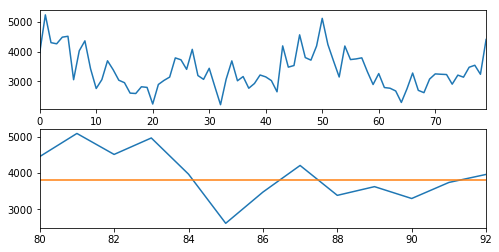

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=plt.figaspect(.5))
y_train = train.iloc[0, 0]
y_train.plot(ax=ax0)
y_test.plot(ax=ax1);
y_pred.plot(ax=ax1);